# Node Representation Learning with attri2vec on DBLP

This is the python implementation of the attri2vec algorithm outlined in paper ***[Attributed Network Embedding Via Subspace Discovery](https://arxiv.org/abs/1901.04095)*** D. Zhang, Y. Jie, X. Zhu and C. Zhang, arXiv:1901.04095, [cs.SI], 2019. The implementation uses the stellargraph libraries.


## attri2vec

attri2vec learns node representations by performing a linear/non-linear mapping on node content attributes. To make the learned node representations respect structural similarity, [`DeepWalk`](https://dl.acm.org/citation.cfm?id=2623732)/[`node2vec`](https://snap.stanford.edu/node2vec) learning mechanism is used to make nodes sharing similar random walk context nodes represented closely in the subspace, which is achieved by maximizing the occurrence probability of context nodes conditioned on the representation of the target nodes. The probability is modelled by Softmax and negative sampling is used to speed up its calculation. This makes attri2vec equivalent to predict whether a node occurs in the given target node's context in random walks with the representation of the target node, by minimizing the cross-entropy loss. 

In implementation, node embeddings are learnt by solving a simple classification task: given a large set of "positive" `(target, context)` node pairs generated from random walks performed on the graph (i.e., node pairs that co-occur within a certain context window in random walks), and an equally large set of "negative" node pairs that are randomly selected from the graph according to a certain distribution, learn a binary classifier that predicts whether arbitrary node pairs are likely to co-occur in a random walk performed on the graph. Through learning this simple binary node-pair-classification task, the model automatically learns an inductive mapping from attributes of nodes to node embeddings in a low-dimensional vector space, which preserves structural and feature similarities of the nodes. 

To train the attri2vec model, we first construct a training set of nodes, which is composed of an equal number of positive and negative `(target, context)` pairs from the graph. The positive `(target, context)` pairs are the node pairs co-occurring on random walks over the graph whereas the negative node pairs are the sampled randomly from the global node degree distribution of the graph. In attri2vec, each node is attached with two kinds of embeddings: 1) the inductive 'input embedding', i.e, the objective embedding, obtained by perform a linear/non-linear transformation on node content features, and 2) 'output embedding', i.e., the parameter vector used to predict its occurrence as a context node, obtained by looking up a parameter table. Given a `(target, context)` pair, attri2vec outputs a predictive value to indicate whether it is positive or negative, which is obtained by performing the dot product of the 'input embedding' of the target node and the 'output embedding' of the context node, followed by a sigmoid activation. 

The entire model is trained end-to-end by minimizing the binary cross-entropy loss function with regards to predicted node pair labels and true node pair labels, using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' node pairs generated on demand and fed into the model.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec, link_classification

from tensorflow import keras

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

## Loading DBLP network data

This demo uses a DBLP citation network, a subgraph extracted from [DBLP-Citation-network V3](https://aminer.org/citation). To form this subgraph, papers from four subjects are extracted according to their venue information: *Database, Data Mining, Artificial Intelligence and Computer Vision*, and papers with no citations are removed. The DBLP network contains 18,448 papers and 45,661 citation relations. From paper titles, we construct 2,476-dimensional binary node feature vectors, with each element indicating the presence/absence of the corresponding word. By ignoring the citation direction, we take the DBLP subgraph as an undirected network.

The dataset used in this demo can be downloaded from https://www.kaggle.com/daozhang/dblp-subgraph.
The following is the description of the dataset:

> The content.txt file contains descriptions of the papers in the following format:

 		<paper_id> <word_attributes> <class_label> <publication_year>
        
> The first entry in each line contains the unique integer ID (ranging from 0 to 18,447) of the paper followed by binary values indicating whether each word in the vocabulary is present (indicated by 1) or absent (indicated by 0) in the paper. Finally, the last two entries in the line are the class label and the publication year of the paper.
> The edgeList.txt file contains the citation relations. Each line describes a link in the following format:
		
        <ID of paper1> <ID of paper2>
        
> Each line contains two paper IDs, with paper2 citing paper1 or paper1 citing paper2.


Download and unzip the dblp-subgraph.zip file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the "DBLP" directory containing "content.txt" and "edgeList.txt").

In [2]:
data_dir = "~/data/DBLP"

Load the graph from the edgelist.

In [3]:
edgelist = pd.read_csv(os.path.join(data_dir, "edgeList.txt"), sep='\t', header=None, names=["source", "target"])
edgelist["label"] = "cites"  # set the edge type

Load paper content features, subjects and publishing years.

In [4]:
feature_names = ["w_{}".format(ii) for ii in range(2476)]
node_column_names =  feature_names + ["subject", "year"]
node_data = pd.read_csv(os.path.join(data_dir, "content.txt"), sep='\t', header=None, names=node_column_names)

Construct the graph from edge list.

In [5]:
G_nx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

Specify node types.

In [6]:
nx.set_node_attributes(G_nx, "paper", "label")

Get node features.

In [7]:
node_features = node_data[feature_names]

Create the Stellargraph with node features.

In [8]:
G = sg.StellarGraph(G_nx, node_features=node_features)

In [9]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 18448, Edges: 45611

 Node types:
  paper: [18448]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [45611]



## Train attri2vec on the DBLP Subgraph

Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk.

In [10]:
nodes = list(G.nodes())
number_of_walks = 4
length = 5

Create the UnsupervisedSampler instance with the relevant parameters passed to it.

In [11]:
unsupervised_samples = UnsupervisedSampler(G, nodes=nodes, length=length, number_of_walks=number_of_walks)

Set the batch size and the number of epochs. 

In [12]:
batch_size = 50
epochs = 8

Define an attri2vec training generator, which generates a batch of (feature of target node, index of context node, label of node pair) pairs per iteration.

In [13]:
train_gen = Attri2VecLinkGenerator(G, batch_size).flow(unsupervised_samples)

Running Attri2VecLinkGenerator with an estimated 14758 batches generated on the fly per epoch.


Building the model: a 1-hidden-layer node representation ('input embedding') of the `target` node and the parameter vector ('output embedding') for predicting the existence of `context node` for each `(target context)` pair, with a link classification layer performed on the dot product of the 'input embedding' of the `target` node and the 'output embedding' of the `context` node.

Attri2Vec part of the model, with a 128-dimenssion hidden layer, no bias term and no normalization. (Normalization can be set to 'l2'). 

In [14]:
layer_sizes = [128]
attri2vec = Attri2Vec(
    layer_sizes=layer_sizes, generator=train_gen, bias=False, normalize=None
)

In [15]:
# Build the model and expose input and output sockets of attri2vec, for node pair inputs:
x_inp, x_out = attri2vec.build()

W0925 16:19:56.064584 140736388883392 deprecation.py:506] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0925 16:19:56.085483 140736388883392 deprecation.py:506] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Use the link_classification function to generate the prediction, with the 'ip' edge embedding generation method and the 'sigmoid' activation, which actually performs the dot product of the 'input embedding' of the target node and the 'output embedding' of the context node followed by a sigmoid activation. 

In [16]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method='ip'
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the Attri2Vec encoder and prediction layer into a Keras model, and specify the loss.

In [17]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

Train the model.

In [18]:
history = model.fit_generator(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=1,
    shuffle=True,
)

Epoch 1/8


W0925 16:19:56.485485 140736388883392 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


14759/14759 [==============================] - 371s 25ms/step - loss: 0.7013 - binary_accuracy: 0.5400
Epoch 2/8
14759/14759 [==============================] - 373s 25ms/step - loss: 0.6139 - binary_accuracy: 0.6296
Epoch 3/8
14759/14759 [==============================] - 379s 26ms/step - loss: 0.5194 - binary_accuracy: 0.7376
Epoch 4/8
14759/14759 [==============================] - 376s 25ms/step - loss: 0.4491 - binary_accuracy: 0.7930
Epoch 5/8
14759/14759 [==============================] - 378s 26ms/step - loss: 0.4003 - binary_accuracy: 0.8237
Epoch 6/8
14759/14759 [==============================] - 382s 26ms/step - loss: 0.3669 - binary_accuracy: 0.8434
Epoch 7/8
14759/14759 [==============================] - 380s 26ms/step - loss: 0.3407 - binary_accuracy: 0.8566
Epoch 8/8
14759/14759 [==============================] - 379s 26ms/step - loss: 0.3204 - binary_accuracy: 0.8673


##  Visualise Node Embeddings

Build the node based model for predicting node representations from node content attributes with the learned parameters. Below a Keras model is constructed, with x_inp[0] as input and x_out[0] as output. Note that this model's weights are the same as those of the corresponding node encoder in the previously trained node pair classifier.

In [19]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

Get the node embeddings by applying the learned mapping function to node content features.

In [20]:
node_ids = node_data.index
node_gen = Attri2VecNodeGenerator(G, batch_size).flow(node_ids)
node_embeddings = embedding_model.predict_generator(node_gen, workers=1, verbose=1)

369/369 [==============================] - 1s 2ms/step


Get node subjects.

In [21]:
node_targets = [ node_data["subject"][node_id] for node_id in node_ids ]

Transform the embeddings to 2d space for visualisation.

In [22]:
transform = TSNE # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

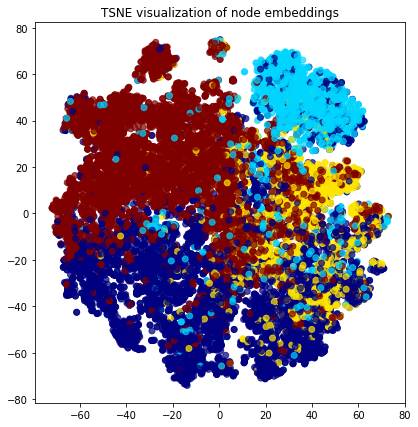

In [23]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = { l: i for i, l in enumerate(np.unique(node_targets)) }
node_colours = [ label_map[target] for target in node_targets ]

plt.figure(figsize=(7,7))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, cmap="jet", alpha=alpha)
plt.title('{} visualization of node embeddings'.format(transform.__name__))
plt.show()

## Node Classification Task

The embeddings learned by `attri2vec` can be used as feature vectors in downstream tasks, such as node classification and link prediction.

In this example, we will use the `attri2vec` node embeddings to train a classifier to predict the subject of a paper in DBLP.

In [24]:
# X will hold the 128-dimensional input features
X = node_embeddings  
# y holds the corresponding target values
y = np.array(node_targets)

### Data Splitting

We split the data into train and test sets. 

We use 10% of the data for training and the remaining 90% for testing as a hold out test set.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Array shapes:
 X_train = (1844, 128)
 y_train = (1844,)
 X_test = (16604, 128)
 y_test = (16604,)


### Classifier Training

We train a Logistic Regression classifier on the training data. 

In [26]:
clf = LogisticRegressionCV(
    Cs=10, 
    cv=10, 
    scoring="accuracy",
    verbose=False,
    multi_class='ovr',
    max_iter=2000
)
clf.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=10, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=2000, multi_class='ovr', n_jobs=None,
                     penalty='l2', random_state=None, refit=True,
                     scoring='accuracy', solver='lbfgs', tol=0.0001,
                     verbose=False)

Predict the hold-out test set.

In [27]:
y_pred = clf.predict(X_test)

Calculate the accuracy of the classifier on the test set.

In [28]:
accuracy_score(y_test, y_pred)

0.8048662972777644